# Classifying News Articles as Real or Fake News

In [117]:
import tensorflow as tf
import numpy as np
import pandas as pd
import sklearn
from sklearn.model_selection import train_test_split
from google.colab import files
import io
from collections import Counter, defaultdict
import matplotlib.pyplot as plt
import re
from sklearn.preprocessing import StandardScaler
import nltk
from nltk.stem import PorterStemmer
nltk.download('stopwords')
ps = PorterStemmer()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Naive Bayes

# Preprocessing

## I. Read in data

In [5]:
uploaded = files.upload()

Saving fake_or_real_news.csv to fake_or_real_news.csv


In [212]:
df = pd.read_csv(io.BytesIO(uploaded['fake_or_real_news.csv']))
df.head()

,Unnamed: 0,title,text,label
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL
3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL


## II. Separate data into features / labels for train & test sets

In [213]:
from nltk.corpus import stopwords
stop = stopwords.words('english')
labels = df.iloc[:, 3]
feats = df.iloc[:, 2]
for i, s in enumerate(feats):
  feats[i] = s.replace('\n', '')
train_x, test_x, train_y, test_y = train_test_split(feats, labels, test_size=.2, random_state=42)
train_x = train_x.to_numpy()
test_x = test_x.to_numpy()
train_y = train_y.to_numpy()
test_y = test_y.to_numpy()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


## III. Plot distribution of labels

(5068,)

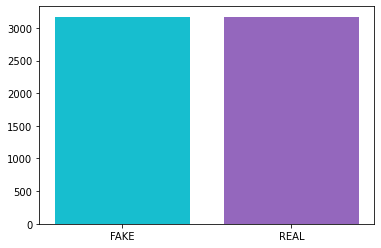

In [214]:
graph_counts = Counter(labels)
x_axis = list(graph_counts.keys())
y_axis = list(graph_counts.values())
plt.bar(x_axis, y_axis, color=['tab:cyan', 'tab:purple'])
train_x.shape

## IV. Remove all punctuation and lowercase all sentences

In [215]:
print(train_x.shape)
for i in range(train_x.shape[0]):
  train_x[i] = re.sub(r'[^\w\s]', '', train_x[i])
train_x.shape

(5068,)


(5068,)

# Naive Bayes

## I. Assemble vocab

In [216]:
print(train_x.shape)
vocab = set()
for sentence in train_x:
  for word in sentence.split(' '):
    vocab.add(word)

(5068,)


## II. Compute word counts for each label

In [217]:
total_counts = defaultdict(int)
word_counts = defaultdict(lambda: Counter())
for label in graph_counts.keys():
  for (s, l) in zip(train_x, train_y):
    if l != label:
      continue
    total_counts[label] += len(s)
    word_counts[label] += Counter(s.split(' '))

## III. Compute weights for each label

In [218]:
label_weights = defaultdict(float)
label_counts = Counter(train_y)
for (label, count) in label_counts.items():
  label_weights[label] = np.log(count / train_y.shape[0])
label_weights

defaultdict(float, {'FAKE': -0.6923582258839132, 'REAL': -0.6939367581769629})

## IV. Compute weights for each word for each label

In [219]:
word_weights = defaultdict(float)
alpha = .001
for label in label_counts.keys():
  for word in vocab:
    count = word_counts[label][word]
    z = np.log((word_counts[label][word] + alpha) / (count + (alpha * len(vocab))))
    word_weights[label, word] = z + label_weights[label]

# Test against test set

In [220]:
preds = list()
for features in test_x:
  scores = defaultdict(float)
  for word in features.split(' '):
    for label in label_counts.keys():
      scores[label] += word_weights[label, word]
  preds.append('REAL' if scores['REAL'] > scores['FAKE'] else 'FAKE')
acc = (preds == test_y).sum() / len(test_y)
print(f'Accuracy: {round(acc, 3) * 100}')

Accuracy: 90.5
